# Evolution Strategies

In this notebook we explore how to implement both $(\mu,\lambda)$ and $(\mu + \lambda)$ evolution strategies. We show how the evolution process works on multiple continuous benchmark function in two dimensions.

In [84]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random
import pandas as pd
from tqdm import tqdm
from math import pow, log, exp, log10
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = [30, 30]

In [85]:
xls30_ = pd.ExcelFile("./synthetic_data/IOP_AOP_Sun30.xls")
xls60_ = pd.ExcelFile("./synthetic_data/IOP_AOP_Sun60.xls")

xls30 = {}
for sheet_name in xls30_.sheet_names:
    xls30[sheet_name] = xls30_.parse(sheet_name)#.dropna()
    xls30[sheet_name].drop(xls30[sheet_name].index[0:8], inplace=True)
    xls30[sheet_name].drop(xls30[sheet_name].columns[0], axis=1, inplace=True)
    xls30[sheet_name].reset_index(drop=True, inplace=True) 

xls60 = {}
for sheet_name in xls60_.sheet_names:
    xls60[sheet_name] = xls60_.parse(sheet_name)#.dropna(inplace = True)
    xls60[sheet_name].drop(xls60[sheet_name].index[0:8], inplace=True)
    xls60[sheet_name].drop(xls60[sheet_name].columns[0], axis=1, inplace=True)
    xls60[sheet_name].reset_index(drop=True, inplace=True) 

In [86]:
ioccgbands = [f'{l}' for l in range(400,801,10)]
ioccbands_n = [float(b) for b in ioccgbands]
aobands = [412,443,469,488,490,510,531,547,555,645,667,670,678]
sbbands = [405,411,443,455,465,489,510,520,530,550,555,560,565,570,590,619,625,665,670,683]

In [104]:
# SYNTHETHIC DATA
x = np.linspace(400, 800, num=41)
x_ = np.linspace(400, 800, num=401)

inputs = []
for i in range(500): # 500 data points at 30 deg solar zenith
    Rrs = xls30['Rrs'].loc[i]
    Rrs443 = np.interp(443, x, Rrs)
    Rrs490 = np.interp(490, x, Rrs)
    Rrs510 = np.interp(510, x, Rrs)
    Rrs555 = np.interp(555, x, Rrs)
    R = max([b/Rrs555 for b in [Rrs443,Rrs490,Rrs510]])

    datapoint30 = (log(R),)
    inputs.append(datapoint30)

    Rrs = xls60['Rrs'].loc[i] # 500 data points at 60 deg solar zenith
    Rrs443 = np.interp(443, x, Rrs)
    Rrs490 = np.interp(490, x, Rrs)
    Rrs510 = np.interp(510, x, Rrs)
    Rrs555 = np.interp(555, x, Rrs)
    R = max([b/Rrs555 for b in [Rrs443,Rrs490,Rrs510]])

    datapoint60 = (log(R),)
    inputs.append(datapoint60)

outputs = []
for i in range(500):
    aph = xls30['a_ph'].loc[i]
    aph443 = np.interp(443, x, aph)
    aph555 = np.interp(555, x, aph)
    chla = pow(aph443/0.05, 1/0.626)

    datapoint30 = (log(chla),)
    outputs.append(datapoint30)

    aph = xls60['a_ph'].loc[i]
    aph443 = np.interp(443, x, aph)
    aph555 = np.interp(555, x, aph)
    chla = pow(aph443/0.05, 1/0.626)
    
    datapoint60 = (log(chla),)
    outputs.append(datapoint60)


In [88]:
# SEABASS DATA SET
Inputs = []
Outputs = []

with open('nomad_seabass_v2.a_2008200.txt', 'r') as seabass:
    lines = seabass.readlines()
    fields = lines[88][8:].split(',')

    for i in range(91, 4550):
        line = lines[i]
        content = line.split(',')
        lw443 = float(content[fields.index('lw443')])
        if lw443 == -999:
            continue
        lw489 = float(content[fields.index('lw489')])
        if lw489 == -999:
            continue
        lw510 = float(content[fields.index('lw510')])
        if lw510 == -999:
            continue
        lw555 = float(content[fields.index('lw555')])
        if lw555 == -999:
            continue
        es443 = float(content[fields.index('es443')])
        if es443 == -999:
            continue
        es489 = float(content[fields.index('es489')])
        if es489 == -999:
            continue
        es510 = float(content[fields.index('es510')])
        if es510 == -999:
            continue
        es555 = float(content[fields.index('es555')])
        if es555 == -999:
            continue
        Rrs443 = lw443/es443
        Rrs489 = lw489/es489
        Rrs510 = lw510/es510
        Rrs555 = lw555/es555

        R = max([b/Rrs555 for b in [Rrs443,Rrs489,Rrs510]])
        inpoint = (log(R),)
        
        chla = float(content[fields.index('chl_a')])
        if chla == -999:
            continue
            
        outpoint = (log(chla),)

        Inputs.append(inpoint)
        Outputs.append(outpoint)
    
    print(len(Inputs))

1220


In [89]:

# ARCTIC OCEAN DATA SET
# Inputs = []
# Outputs = []
with open('arctic_ocean_dataset/Arctic_Ocean_Bio-Optical_Database_Lewis_et_al.csv', 'r') as input:
    lines = input.readlines()
    fields = lines[0].split(',')
    irrs443 = fields.index('rrs443')
    irrs490 = fields.index('rrs490')
    irrs510 = fields.index('rrs510')
    irrs555 = fields.index('rrs555')
    iaph443 = fields.index('aph443')
    ichla = fields.index('chla_HPLC')

    for i in range(2, 3170, 2):
        line = lines[i]
        content = line.split(',')
        if content[1] == 'GREENEDGE':
            continue
        
        rrs443 = (content[irrs443])
        if rrs443 == 'NA':
            continue
        else:
            rrs443 = float(content[irrs443])
        rrs490 = (content[irrs490])
        if rrs490 == 'NA':
            continue
        else:
            rrs490 = float(content[irrs490])
        rrs510 = (content[irrs510])
        if rrs510 == 'NA':
            continue
        else:
            rrs510 = float(content[irrs510])
        rrs555 = (content[irrs555])
        if rrs555 == 'NA':
            continue
        else:
            rrs555 = float(content[irrs555])

        R = max([r/rrs555 for r in [rrs443,rrs490,rrs510]])
        inpoint = (log(R),)

        
        chla = content[ichla]
        if chla == 'NA':
            aph443 = content[iaph443]
            if aph443 == 'NA':
                continue
            chla = pow(float(aph443)/0.05, 1/0.626)
        else:
            chla = float(content[ichla])
            if chla <= 0:
                continue

        outpoint = (log(chla),)

        Inputs.append(inpoint)
        Outputs.append(outpoint)

    print(len(Inputs))



1349


In [91]:
def chla_fit(ind):
    res = 0
    for i, o in zip(inputs, outputs):
        r = i[0]
        res += (o[0] - ind[0] - ind[1]*r - ind[2]*r*r - ind[3]*r*r*r)**2
    return res

def chla_fit_(ind):
    res = 0
    for i, o in zip(Inputs, Outputs):
        r = i[0]
        res += (o[0] - ind[0] - ind[1]*r - ind[2]*r*r - ind[3]*r*r*r)**2
    return res

In the following class we define a ES algorithm with the following parameters:

- `mu`, `lmb` are the values $\mu$ and $\lambda$ of the ES algorithm
- `fit` is the fitness function to employ
- `limits` is a list of pairs of numbers representing the lower and upper limits of the search space for each of the coordinates
- `plus` (default `False`). If false then a $(\mu, \lambda)$ ES is used, if true then a $(\mu + \lambda)$ ES is used instead
- `variance` (default `0.5`). Mutation is performed by adding a gaussian noise to each of the coordinates extracted from $N(0,\sigma^2)$ where $\sigma^2$ is given by this parameter

In [92]:
class chla_ES(object):
    
    def __init__(self, mu, lmb, fit, limits, plus=False, variance=0.5):
        self.mu = mu
        self.lmb = lmb
        self.plus = plus
        self.fit = fit
        self.limits = limits
        self.pop = []
        self.variance = variance
        for i in range(0,self.lmb):
            individual = []
            for lower, upper in self.limits:
                individual.append(random.uniform(lower, upper))
            self.pop.append(individual)
        self.best = min(self.pop, key=self.fit)
    
    def generation(self):
        self.truncated_selection()
        new_pop = []
        for i in range(0, self.lmb):
            new_ind = self.mutation(self.pop[i%self.mu])
            new_pop.append(new_ind)
        if self.plus:
            self.pop = self.pop + new_pop
        else:
            self.pop = new_pop
        candidate_best = min(self.pop, key=self.fit)
        if self.fit(self.best) > self.fit(candidate_best):
            self.best = candidate_best
    
    def mutation(self, individual):
        # This is simply the addition of a gaussian noise to each coordinate.
        # There is the possibility of defining an *adaptive* mutation
        new_ind = []
        for i, coord in enumerate(individual):
            tmp = coord + random.gauss(0, self.variance)
            if tmp < self.limits[i][0]:
                tmp = self.limits[i][0]
            if tmp > self.limits[i][1]:
                tmp = self.limits[i][1]
            new_ind.append(tmp)
        return new_ind
    
    def truncated_selection(self):
        list.sort(self.pop, key=self.fit)
        self.pop = self.pop[0:self.mu]
        
    def __str__(self):
        s = f"Best individual: {self.best}\n"
        s += f"with fitness {self.fit(best)}"
        return s

def display_pop2D(pop, ax):
    ax.scatter([x for x, y in pop], [y for x, y in pop], color='yellow')

Train the model on synthetic data

In [93]:

random.seed(0)
ES_s = chla_ES(5, 35, chla_fit, [[-4,4] for _ in range(4)], plus=True, variance=0.2)
pop_list = [ES_s.pop]
n_gen = 500
for i in tqdm(range(0, n_gen)):
    ES_s.generation()
    pop_list.append(ES_s.pop)
print(ES_s.best)
print(ES_s.fit(ES_s.best))

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:21<00:00, 23.03it/s]

[0.10217470506317455, -3.490003266820097, 1.76151657893713, -0.510500346248298]
183.77315409068248


Train the model on in-situ data

In [94]:
random.seed(0)
ES_r = chla_ES(7, 50, chla_fit_, [[-5,5] for _ in range(4)], plus=True, variance=0.2)
pop_list = [ES_r.pop]
n_gen = 500
for i in tqdm(range(0, n_gen)):
    ES_r.generation()
    pop_list.append(ES_r.pop)
print(ES_r.best)
print(ES_r.fit(ES_r.best))

100%|██████████| 500/500 [00:46<00:00, 10.73it/s]

[0.5650564550898061, -3.1130471753038, 1.7506801198224586, -0.5487648746149675]
663.8386656554785


In [103]:
SSt = 0
mean = 0
SSreg = 0
def chla(R):
    return sum([ES_s.best[i] * pow(R,i) for i in range(4)])

for i in range(len(outputs)):
    mean += outputs[i][0]
mean /= len(outputs)

for i, o in zip(inputs, outputs):
    output = chla(i[0])
    SSreg += (mean - output) ** 2

for i in range(len(inputs)):
    SSt += (outputs[i][0] - mean) ** 2

Rsq = SSreg/SSt

print('R-squared:', Rsq)

R-squared: 0.9620954180659174


In [96]:
def chla(R):
    # return pow(10, sum([ES.best[i] * pow(R,i) for i in range(5)]))
    return sum([ES_s.best[i] * pow(R,i) for i in range(4)])

logchla_pred = []
for input in inputs:
    logchla_pred.append((chla(input[0])))

logchla_real = [out[0] for out in outputs]
logR = [i[0] for i in inputs]

logchla_pred_ = []
for input in Inputs:
    logchla_pred_.append((chla(input[0])))

logchla_real_ = [out[0] for out in Outputs]

logR = [i[0] for i in inputs]

def model(r):
    res = sum([ES_s.best[i]*pow(r,i) for i in range(4)])
    if res < 0:
        return -7
    return log(sum([ES_s.best[i]*pow(r,i) for i in range(4)]))

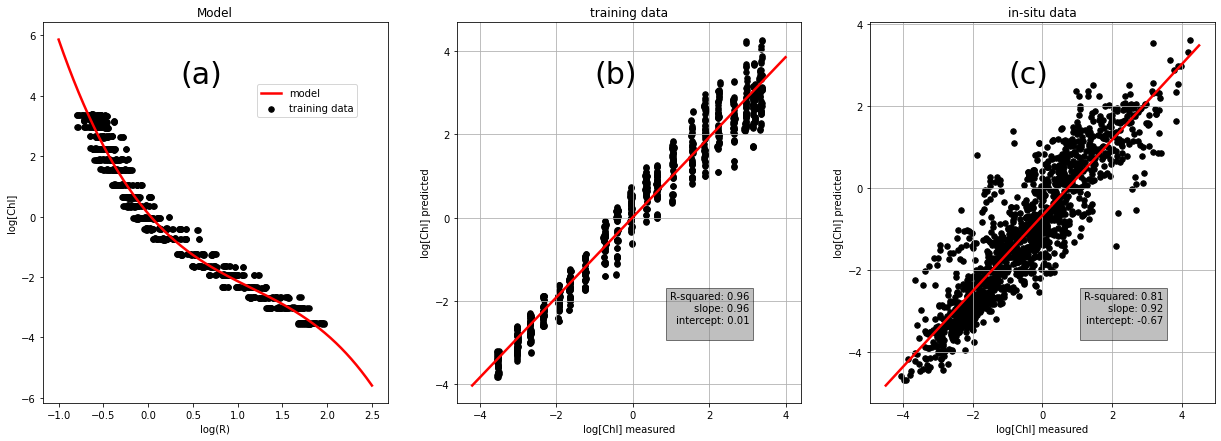

In [97]:
fig, axs= plt.subplots(1, 3, figsize=(21,7))
axs[1].scatter(logchla_real, logchla_pred, c='black', s=30)
axs[1].set_xlabel('log[Chl] measured')
axs[1].set_ylabel('log[Chl] predicted')
axs[1].set_title('training data')
fit = LinearRegression().fit(np.asarray(logchla_real).reshape(-1, 1), np.asarray(logchla_pred).reshape(-1, 1))
y = fit.predict(np.linspace(-4.2,4,100).reshape(-1, 1))
axs[1].plot(np.linspace(-4.2,4,100), y, c='r', lw=2.5)

Rsq = fit.score(np.asarray(logchla_real).reshape(-1, 1), np.asarray(logchla_pred).reshape(-1, 1))
slope = fit.coef_[0][0]
intercept = fit.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
            f'slope: {round(slope,2)}\n'
            f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[1].text(0.85, 0.18, stats, fontsize=10, bbox=bbox,
        transform=axs[1].transAxes, horizontalalignment='right')

axs[2].scatter(logchla_real_, logchla_pred_, c='black', s=30)
axs[2].set_xlabel('log[Chl] measured')
axs[2].set_ylabel('log[Chl] predicted')
axs[2].set_title('in-situ data')
fit = LinearRegression().fit(np.asarray(logchla_real_).reshape(-1, 1), np.asarray(logchla_pred_).reshape(-1, 1))
y = fit.predict(np.linspace(-4.5,4.5,100).reshape(-1, 1))
axs[2].plot(np.linspace(-4.5,4.5,100), y, c='r', lw=2.5)

Rsq = fit.score(np.asarray(logchla_real_).reshape(-1, 1), np.asarray(logchla_pred_).reshape(-1, 1))
slope = fit.coef_[0][0]
intercept = fit.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
            f'slope: {round(slope,2)}\n'
            f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[2].text(0.85, 0.18, stats, fontsize=10, bbox=bbox,
        transform=axs[2].transAxes, horizontalalignment='right')

x = np.linspace(-1,2.5,500)
y = [chla(r) for r in x]
axs[0].scatter(logR, logchla_real, c='black', s=30,label= 'training data')
axs[0].plot(x,y, c='r', lw=2.5, label='model')
axs[0].set_xlabel('log(R)')
axs[0].set_ylabel('log[Chl]')
axs[0].set_title('Model')
axs[0].legend(loc=[0.62, 0.75])

for i in range(1,3):
    axs[i].grid(True)
for ax,label in zip(axs, ['(a)','(b)','(c)']):
        ax.text(0.1, 0.9, label, fontsize=30, transform=ax.transAxes, va='top', position=(0.4,0.9))
# plt.plot(x,y)
plt.show()

In [98]:
SSt = 0
mean = 0
SSreg = 0
def chla(R):
    # return pow(10, sum([ES.best[i] * pow(R,i) for i in range(5)]))
    return sum([ES_r.best[i] * pow(R,i) for i in range(4)])

for i in range(len(Outputs)):
    mean += Outputs[i][0]
mean /= len(Outputs)

for i, o in zip(Inputs, Outputs):
    output = chla(i[0])
    SSreg += (mean - output) ** 2

for i in range(len(Inputs)):
    SSt += (Outputs[i][0] - mean) ** 2

# Rsq = []
# for i in range(len(SSr)):
#     Rsq.append(1-SSr[i]/SSt[i])

Rsq = SSreg/SSt

print('R-squared:', Rsq)

R-squared: 0.8162641500895933


In [106]:
def chla(R):
    # return pow(10, sum([ES.best[i] * pow(R,i) for i in range(5)]))
    return sum([ES_r.best[i] * pow(R,i) for i in range(4)])
def chla_s(R):
    return sum([ES_s.best[i] * pow(R,i) for i in range(4)])
def expchla(R):
    return pow( 10, sum([ES_r.best[i] * pow(log(R),i) for i in range(4)]) )

logchla_pred = []
explogchla_pred = []
for input in Inputs:
    logchla_pred.append((chla(input[0])))
    explogchla_pred.append((expchla(pow(10, input[0]))))

logchla_real = [out[0] for out in Outputs]
explogchla_real = [pow(10, o[0]) for o in Outputs]
logR = [i[0] for i in Inputs]
expLogR = [pow(10, i[0]) for i in Inputs]

def model(r):
    res = sum([ES_r.best[i]*pow(r,i) for i in range(4)])
    if res < 0:
        return -7
    return log(sum([ES_r.best[i]*pow(r,i) for i in range(4)]))

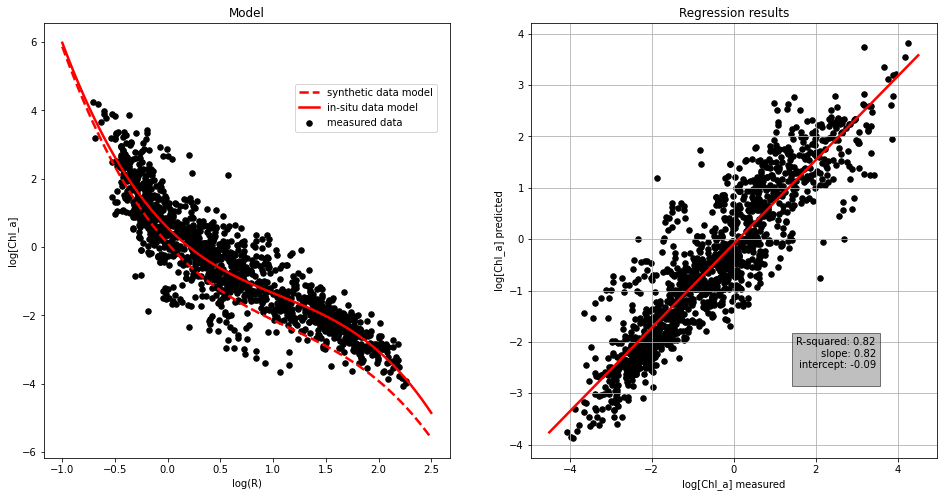

In [108]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].scatter(logR, logchla_real, c='black', s=30, label='measured data')
x = np.linspace(-1,2.5,500)
y = [chla_s(r) for r in x]
axs[0].plot(x,y, '--', c='r', lw=2.5, label='synthetic data model')

x = np.linspace(-1,2.5,500)
y = [chla(r) for r in x]
axs[0].plot(x,y, c='r', lw=2.5, label='in-situ data model')

axs[0].set_xlabel('log(R)')
axs[0].set_ylabel('log[Chl_a]')
axs[0].set_title('Model')
axs[0].legend(loc=[0.62, 0.75])

axs[1].scatter(logchla_real, logchla_pred, c='black', s=30)
fit = LinearRegression().fit(np.asarray(logchla_real).reshape(-1, 1), np.asarray(logchla_pred).reshape(-1, 1))
y = fit.predict(np.linspace(-4.5,4.5,100).reshape(-1, 1))
axs[1].plot(np.linspace(-4.5,4.5,100), y, c='r', lw=2.5)

Rsq = fit.score(np.asarray(logchla_real).reshape(-1, 1), np.asarray(logchla_pred).reshape(-1, 1))
slope = fit.coef_[0][0]
intercept = fit.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
            f'slope: {round(slope,2)}\n'
            f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[1].text(0.85, 0.18, stats, fontsize=10, bbox=bbox,
        transform=axs[1].transAxes, horizontalalignment='right')

axs[1].set_xlabel('log[Chl_a] measured')
axs[1].set_ylabel('log[Chl_a] predicted')
axs[1].set_title('Regression results')
axs[1].grid(True)
plt.show()